--- Data Head (First 5 Rows) ---
   Age                                              Race   \
0   43  Other (American Indian/AK Native, Asian/Pacifi...   
1   47  Other (American Indian/AK Native, Asian/Pacifi...   
2   67                                              White   
3   46                                              White   
4   63                                              White   

                   Marital Status  Unnamed: 3 T Stage  N Stage 6th Stage  \
0  Married (including common law)         NaN       T2      N3      IIIC   
1  Married (including common law)         NaN       T2      N2      IIIA   
2  Married (including common law)         NaN       T2      N1       IIB   
3                        Divorced         NaN       T1      N1       IIA   
4  Married (including common law)         NaN       T2      N2      IIIA   

                                 Grade   A Stage  Tumor Size Estrogen Status  \
0  Moderately differentiated; Grade II  Regional          40   

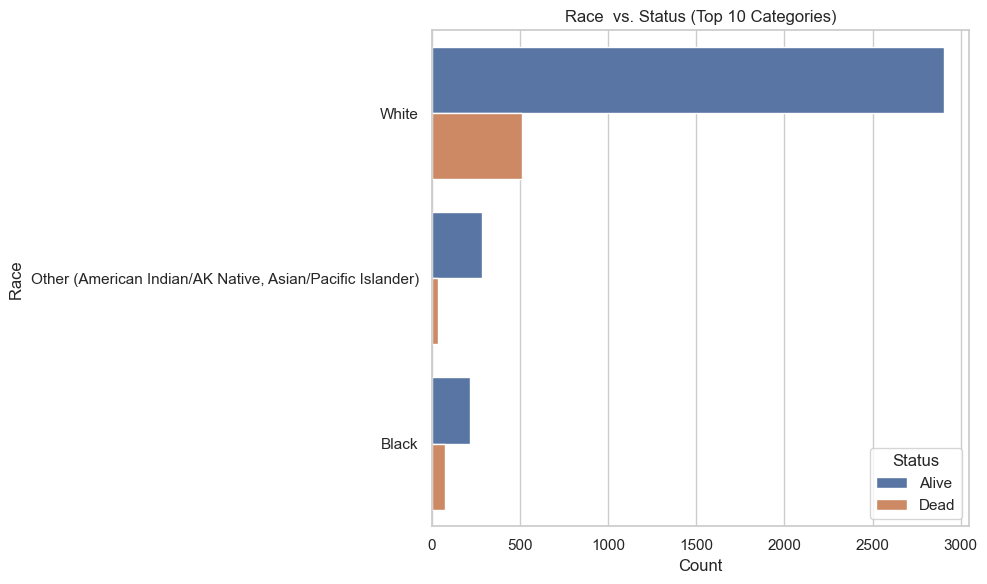


Value Counts for Marital Status:
Marital Status
Married (including common law)    2643
Single (never married)             615
Divorced                           486
Widowed                            235
Separated                           45
Name: count, dtype: int64


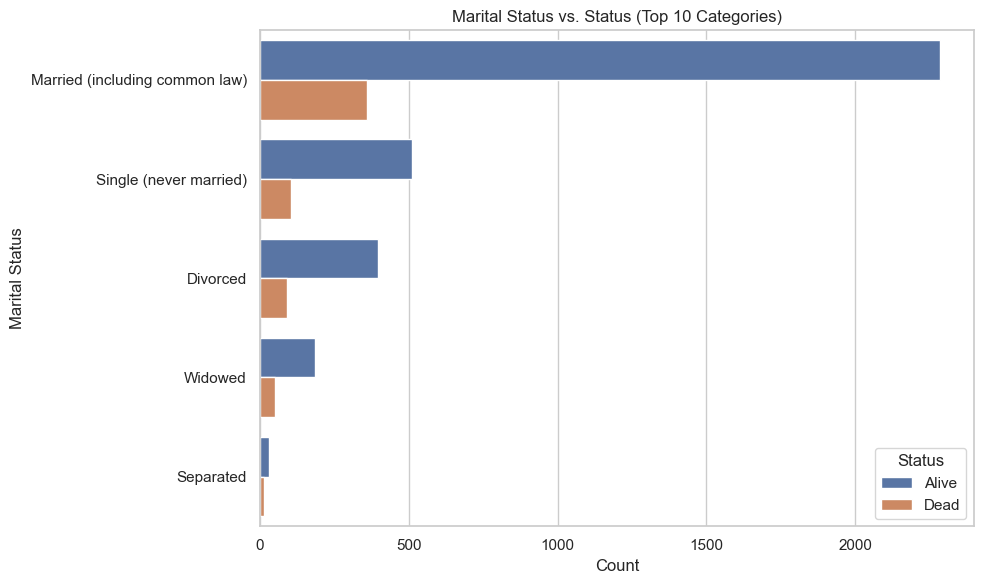


Value Counts for T Stage :
T Stage 
T2    1786
T1    1603
T3     533
T4     102
Name: count, dtype: int64


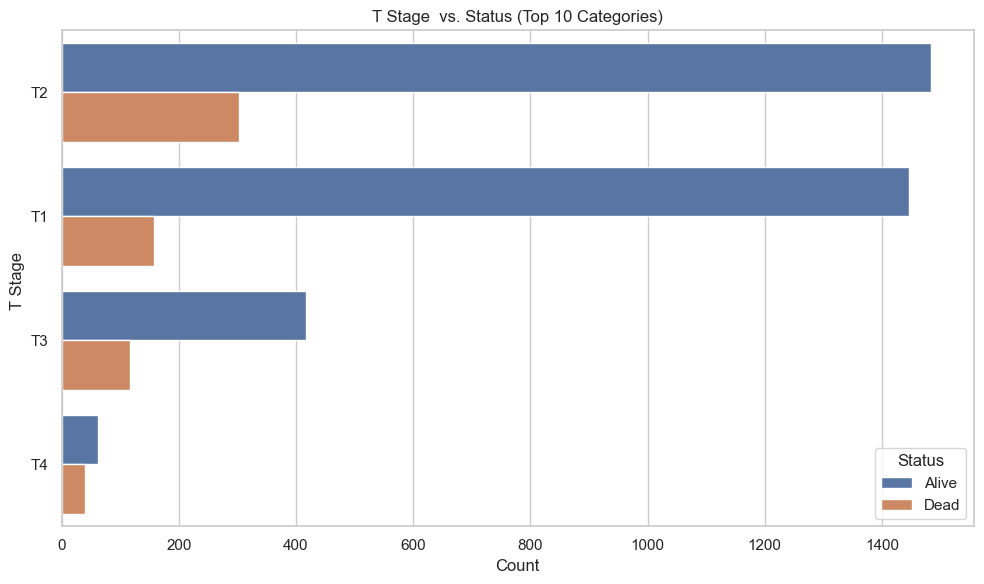


Value Counts for N Stage:
N Stage
N1    2732
N2     820
N3     472
Name: count, dtype: int64


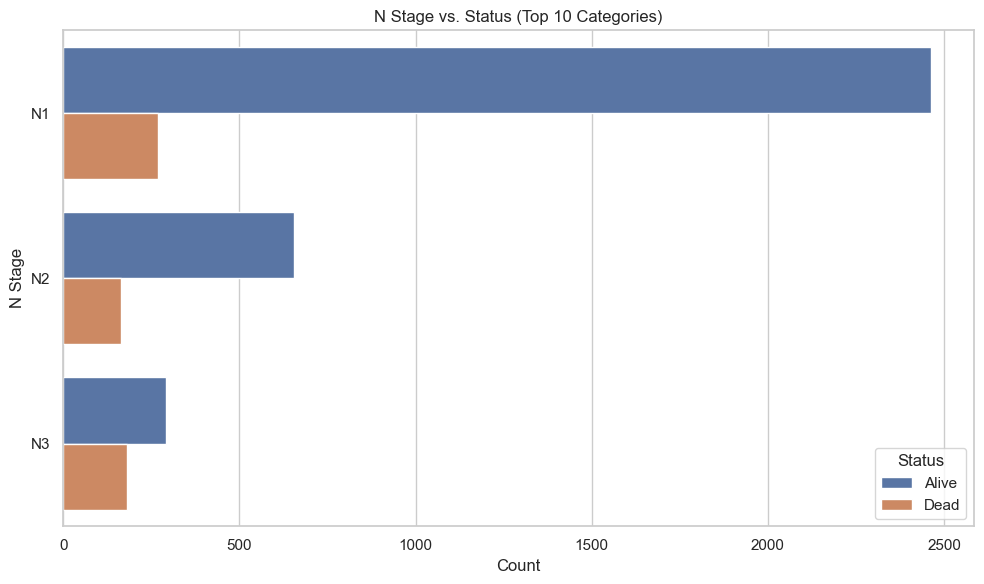


Value Counts for 6th Stage:
6th Stage
IIA     1305
IIB     1130
IIIA    1050
IIIC     472
IIIB      67
Name: count, dtype: int64


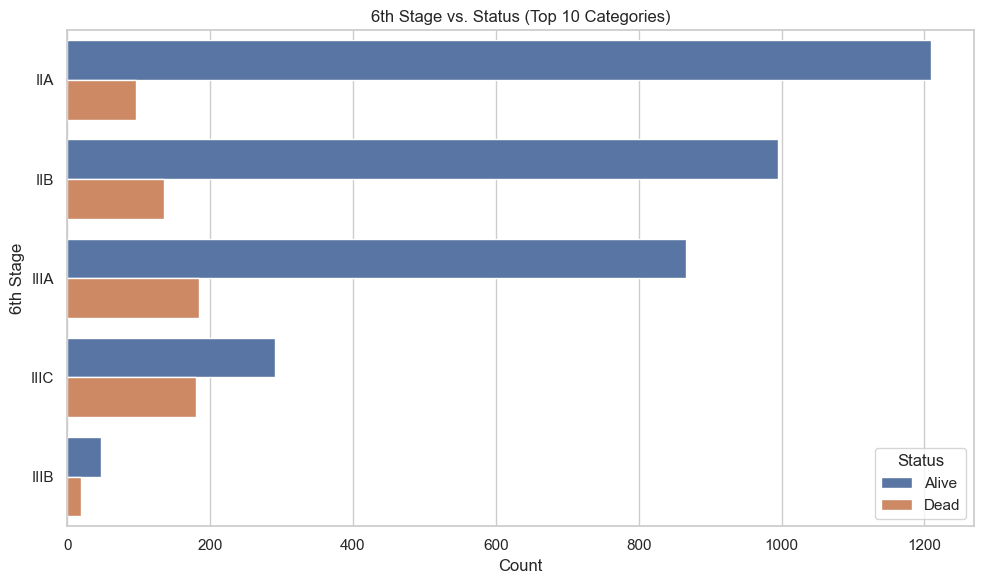


Value Counts for Grade:
Grade
Moderately differentiated; Grade II       2351
Poorly differentiated; Grade III          1111
Well differentiated; Grade I               543
Undifferentiated; anaplastic; Grade IV      19
Name: count, dtype: int64


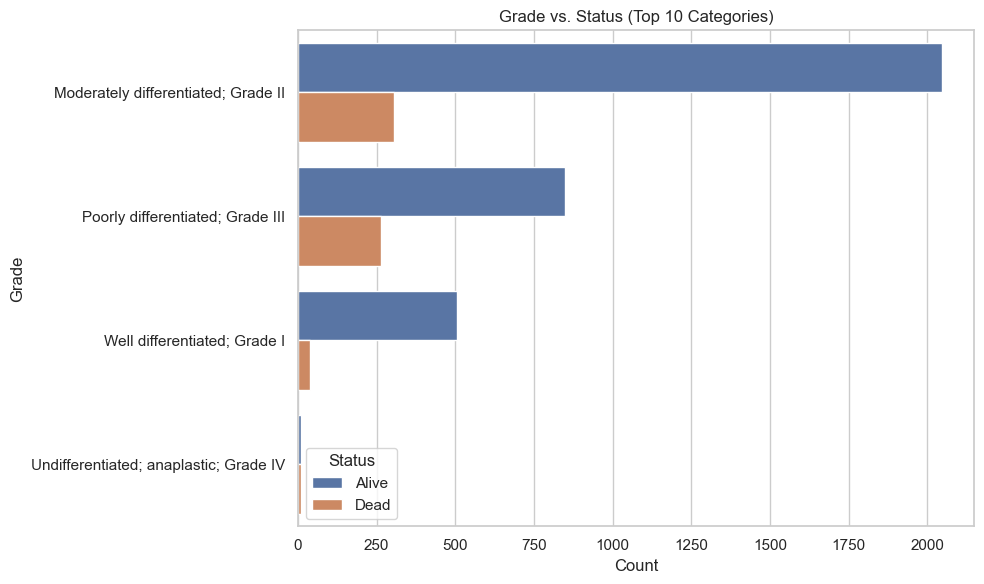


Value Counts for A Stage:
A Stage
Regional    3932
Distant       92
Name: count, dtype: int64


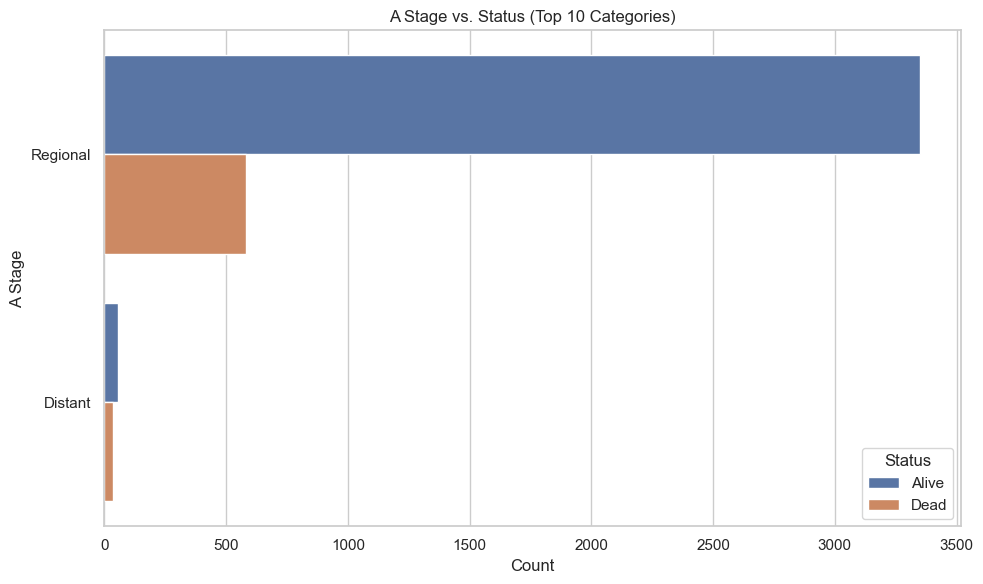


Value Counts for Estrogen Status:
Estrogen Status
Positive    3755
Negative     269
Name: count, dtype: int64


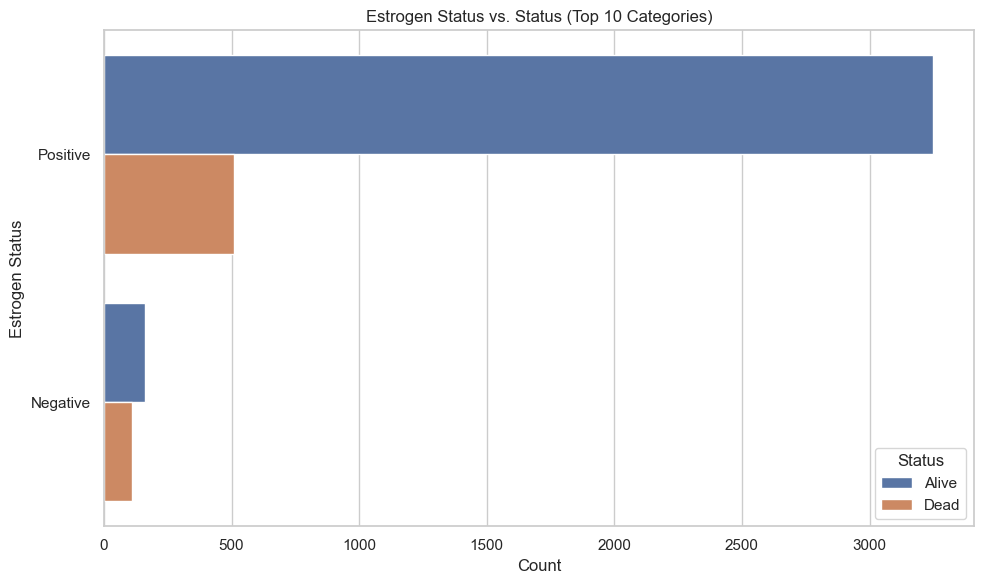


Value Counts for Progesterone Status:
Progesterone Status
Positive    3326
Negative     698
Name: count, dtype: int64


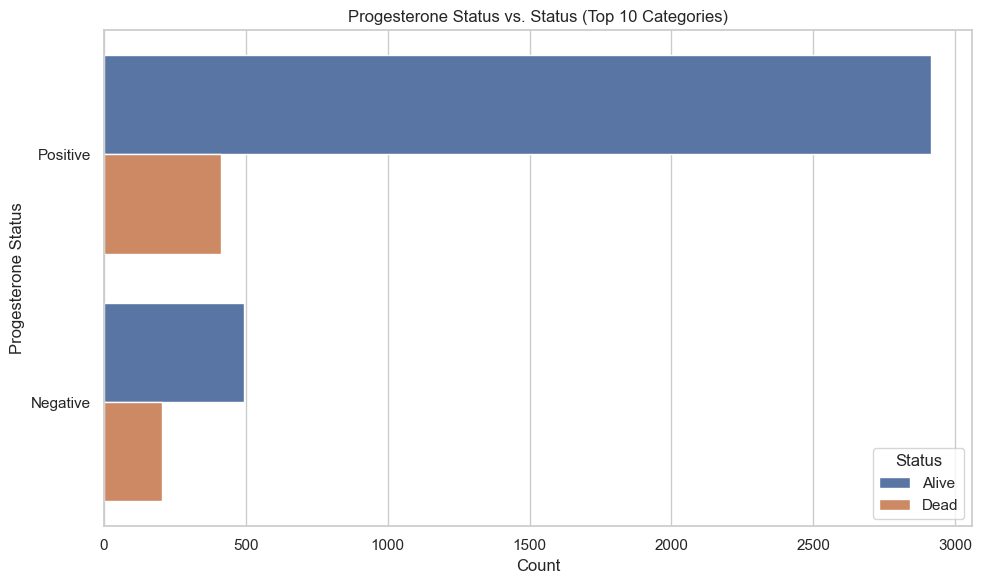

--- Analyzing Numerical Features vs. Status ---


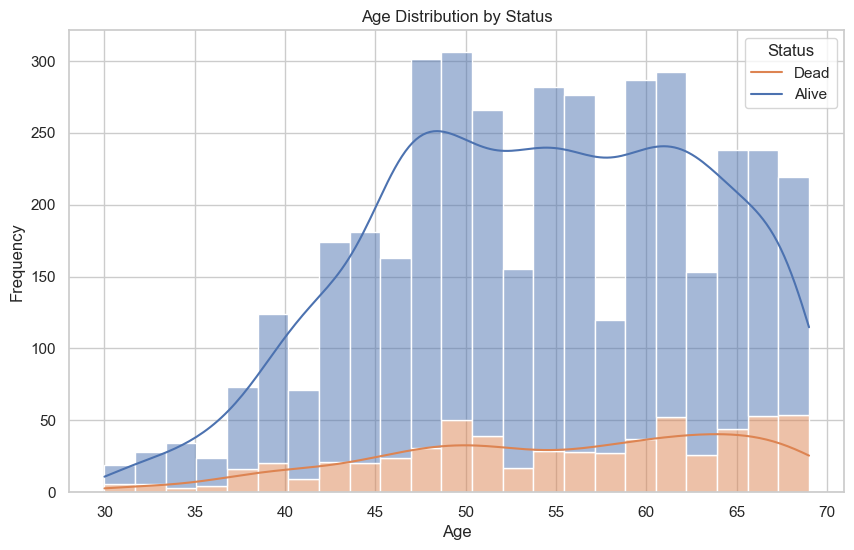

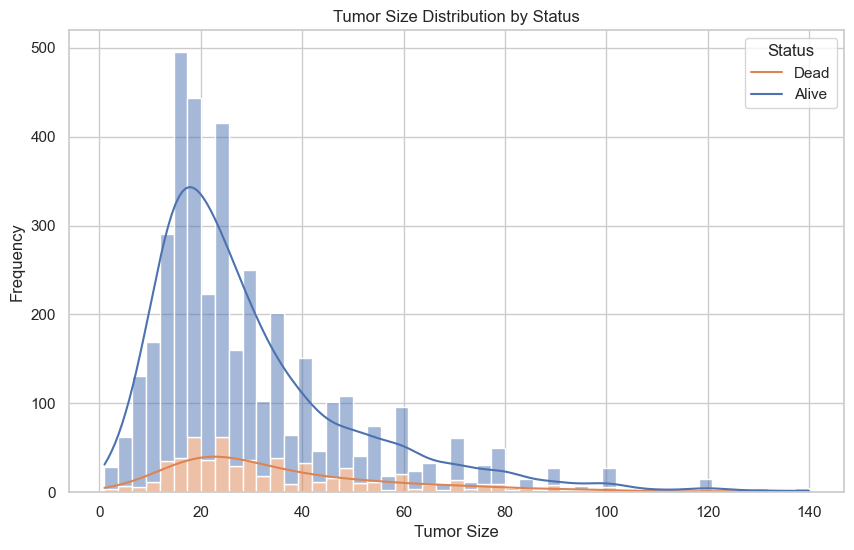

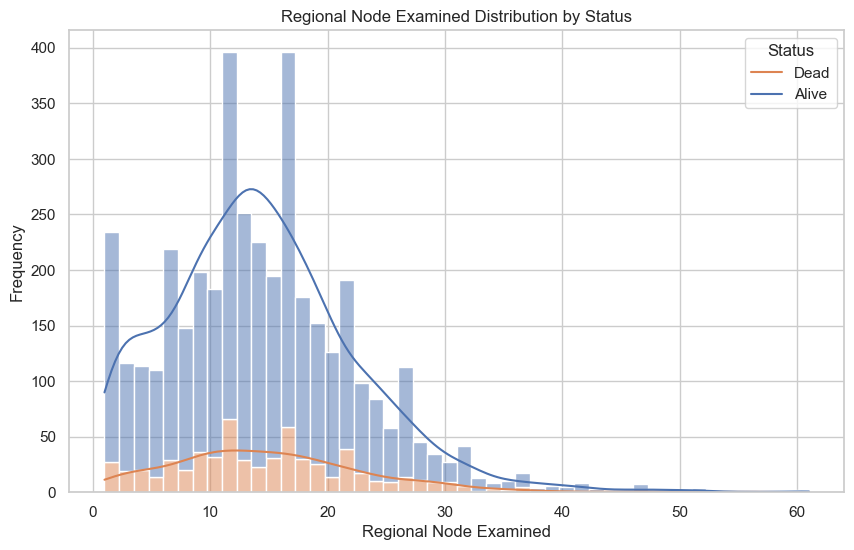

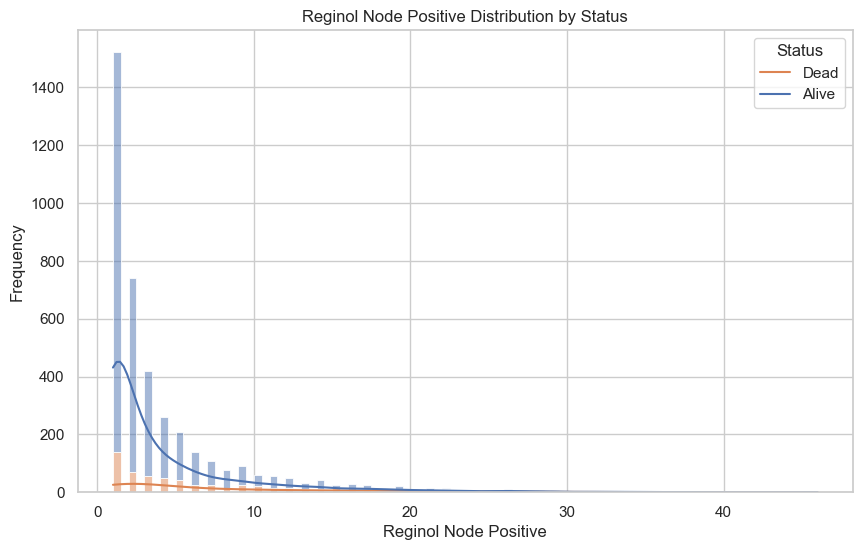

--- Analyzing Survival Months by Status ---


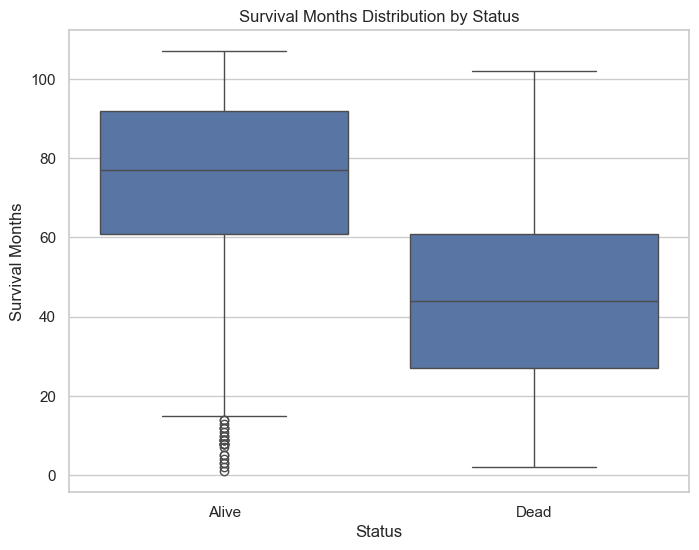

--- Correlation Heatmap (Numerical Features) ---


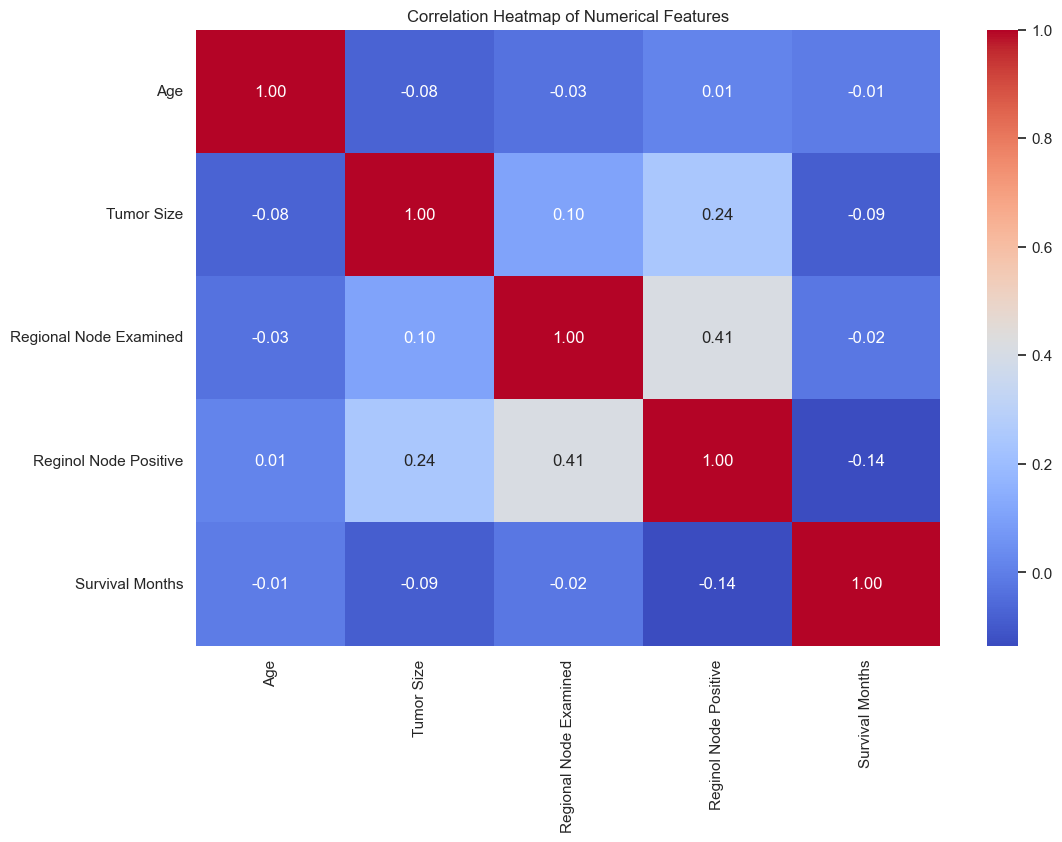


--- Initial EDA Complete ---


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# --- 1. Load Data ---
# Load the new SEER dataset
df = pd.read_csv("../SEER Breast Cancer Dataset.csv")

# --- 2. Initial Data Inspection ---
print("--- Data Head (First 5 Rows) ---")
print(df.head())
print("\n" + "=" * 80 + "\n")

print("--- Data Info (Data Types & Nulls) ---")
df.info()
# This is the corrected line:
print("\n" + "=" * 80 + "\n")

print("--- Descriptive Statistics (Numerical) ---")
# This shows stats for columns like 'Age', 'Tumor Size', etc.
print(df.describe())
print("\n" + "=" * 80 + "\n")

print("--- Descriptive Statistics (Categorical) ---")
# This shows counts, unique values, and top frequencies for text columns
print(df.describe(include="object"))
print("\n" + "=" * 80 + "\n")


# --- 4. Identify Feature Types ---
# We will analyze 'Survival Months' and 'Status' separately as they are outcomes.
target_col = "Status"
outcome_col = "Survival Months"

# Get all other columns as features
all_cols = df.columns.tolist()
# Note: Assuming 'Unnamed: 0' is an index column if it exists.
if "Unnamed: 0" in all_cols:
    all_cols.remove("Unnamed: 0")

# Separate numerical and categorical features for plotting
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
categorical_features = df.select_dtypes(include="object").columns.tolist()

# Remove outcome/target columns from our feature lists
if target_col in categorical_features:
    categorical_features.remove(target_col)

if outcome_col in numerical_features:
    numerical_features.remove(outcome_col)

# Filter out columns with no valid data (all NaN or empty)
# Also exclude columns that start with "Unnamed" (except Unnamed: 0 which was already handled)
valid_numerical_features = []
for col in numerical_features:
    # Skip Unnamed columns (except Unnamed: 0 which was already removed)
    if col.startswith("Unnamed"):
        continue
    # Skip columns that are all NaN or have no valid data
    valid_count = df[col].notna().sum()
    if valid_count > 0:
        valid_numerical_features.append(col)
    else:
        print(f"Skipping {col}: all values are NaN")

numerical_features = valid_numerical_features

# Filter categorical features similarly
valid_categorical_features = []
for col in categorical_features:
    # Skip Unnamed columns
    if col.startswith("Unnamed"):
        continue
    # Skip columns that are all NaN or have no valid data
    valid_count = df[col].notna().sum()
    if valid_count > 0:
        valid_categorical_features.append(col)
    else:
        print(f"Skipping {col}: all values are NaN")

categorical_features = valid_categorical_features

print(f"Identified Numerical Features: {numerical_features}")
print(f"Identified Categorical Features: {categorical_features}")
print("\n" + "=" * 80 + "\n")


# --- 5. Categorical Feature Analysis 📊 ---
print("--- Analyzing Categorical Features vs. Status ---")
for col in categorical_features:
    # Print value counts to understand the categories
    print(f"\nValue Counts for {col}:")
    print(df[col].value_counts().head(10))  # Show top 10

    # Plot countplot
    plt.figure(figsize=(10, 6))
    sns.countplot(
        data=df, y=col, hue=target_col, order=df[col].value_counts().index[:10]
    )
    plt.title(f"{col} vs. Status (Top 10 Categories)")
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.legend(title="Status")
    plt.tight_layout()
    plt.show()


# --- 6. Numerical Feature Analysis 📈 ---
print("--- Analyzing Numerical Features vs. Status ---")
for col in numerical_features:
    # Additional validation: check if column has valid data
    if col not in df.columns:
        print(f"Skipping {col}: column not found")
        continue

    valid_data = df[col].dropna()
    if len(valid_data) == 0:
        print(f"Skipping {col}: no valid data")
        continue

    try:
        # Check if column has enough unique values for KDE
        unique_count = valid_data.nunique()
        use_kde = unique_count > 1  # Only use KDE if more than 1 unique value

        plt.figure(figsize=(10, 6))
        if use_kde:
            sns.histplot(data=df, x=col, hue=target_col, kde=True, multiple="stack")
        else:
            sns.histplot(data=df, x=col, hue=target_col, kde=False, multiple="stack")
        plt.title(f"{col} Distribution by Status")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.legend(title="Status", labels=["Dead", "Alive"])
        plt.show()
    except Exception as e:
        print(f"Error plotting {col}: {e}")
        # Try without KDE if KDE fails
        try:
            plt.figure(figsize=(10, 6))
            sns.histplot(data=df, x=col, hue=target_col, kde=False, multiple="stack")
            plt.title(f"{col} Distribution by Status")
            plt.xlabel(col)
            plt.ylabel("Frequency")
            plt.legend(title="Status", labels=["Dead", "Alive"])
            plt.show()
        except Exception as e2:
            print(f"Could not plot {col}: {e2}")
            continue


# --- 7. Survival Months Analysis ---
print("--- Analyzing Survival Months by Status ---")
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x=target_col, y=outcome_col)
plt.title("Survival Months Distribution by Status")
plt.xlabel("Status")
plt.ylabel("Survival Months")
plt.show()

# --- 8. Correlation Heatmap (Numerical Features Only) ---
print("--- Correlation Heatmap (Numerical Features) ---")
plt.figure(figsize=(12, 8))
# We include 'Survival Months' here to see its correlation with other numerics
numeric_corr_df = df[numerical_features + [outcome_col]]
corr_matrix = numeric_corr_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

print("\n--- Initial EDA Complete ---")

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# --- 1. Load Data ---
print("Loading data...")
df = pd.read_csv("../SEER Breast Cancer Dataset.csv")

# Drop all 'Unnamed' columns (index columns or empty columns)
unnamed_cols = [col for col in df.columns if col.startswith("Unnamed")]
if unnamed_cols:
    df = df.drop(unnamed_cols, axis=1)
    print(f"Dropped {len(unnamed_cols)} Unnamed column(s): {unnamed_cols}")

# --- 2. Define Target and Features ---

# Convert the target 'Status' to a binary format
# 'Alive' = 0 (the 'negative' class)
# 'Dead' = 1 (the 'positive' class)
df["Status"] = df["Status"].map({"Alive": 0, "Dead": 1})

# Define our target (y)
y = df["Status"]

# Define our features (X)
# We MUST drop 'Status' and 'Survival Months'.
# 'Survival Months' is an outcome, not a predictor. Including it would cause data leakage.
X = df.drop(["Status", "Survival Months"], axis=1)

print("Original data shape:", X.shape)
print(f"Target variable 'Status' defined (0=Alive, 1=Dead).")
print("Dropped 'Survival Months' to prevent data leakage.")

# --- 3. Identify Feature Types ---
# Automatically separate numerical and categorical columns
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include="object").columns.tolist()

print(f"\nIdentified {len(numerical_cols)} numerical features:")
print(numerical_cols)
print(f"\nIdentified {len(categorical_cols)} categorical features:")
print(categorical_cols)

# --- 4. Create Preprocessing Pipelines ---

# Numerical pipeline:
# Step 1: Impute missing values with the median (robust to outliers)
# Step 2: Scale data using StandardScaler (mean=0, std=1)
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

# Categorical pipeline:
# Step 1: Impute missing values with the most frequent category
# Step 2: One-hot encode the categories. 'handle_unknown='ignore''
#          prevents errors if the test set has a rare category.
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

# --- 5. Combine Pipelines with ColumnTransformer ---
# This applies the correct transformer to the correct columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ],
    remainder="passthrough",  # Keep any columns not specified (just in case)
)

# --- 6. Split Data into Training and Test Sets ---
# We split BEFORE preprocessing to prevent data leakage
# stratify=y ensures the train and test sets have the same proportion of
# 'Alive' and 'Dead' samples as the original dataset.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,  # 20% for testing
    random_state=42,  # For reproducible results
    stratify=y,  # Essential for classification
)

print(
    f"\nData split into training set (n={len(X_train)}) and test set (n={len(X_test)})."
)

# --- 7. Apply Preprocessing ---
# .fit_transform() on the training data: learns the scalers and encoders
# .transform() on the test data: applies the learned transformations
print("Applying preprocessing pipelines...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# --- 8. Create Processed DataFrames ---
# Get the new feature names after one-hot encoding
feature_names = preprocessor.get_feature_names_out()

# Convert the processed numpy arrays back into DataFrames
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index)
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names, index=X_test.index)

print("Preprocessing complete.")
print("\n--- Processed Training Data (Head) ---")
print(X_train_df.head())
print("\n--- Processed Training Data (Info) ---")
X_train_df.info()

# --- 9. Save Processed Data for Modeling ---
# Save the processed data and the corresponding targets (y)
# Save to the Notebooks directory where this notebook is located
import os

save_dir = (
    os.path.dirname(os.path.abspath("__file__"))
    if "__file__" in globals()
    else os.getcwd()
)

X_train_df.to_csv("X_train_processed.csv", index=False)
X_test_df.to_csv("X_test_processed.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

print("\nProcessed training and testing data saved to CSV files:")
print(" - X_train_processed.csv")
print(" - X_test_processed.csv")
print(" - y_train.csv")
print(" - y_test.csv")
print(f"\nFiles saved to: {os.getcwd()}")
print("\nYou are now ready for modeling!")

Loading data...
Dropped 1 Unnamed column(s): ['Unnamed: 3']
Original data shape: (4024, 13)
Target variable 'Status' defined (0=Alive, 1=Dead).
Dropped 'Survival Months' to prevent data leakage.

Identified 4 numerical features:
['Age', 'Tumor Size', 'Regional Node Examined', 'Reginol Node Positive']

Identified 9 categorical features:
['Race ', 'Marital Status', 'T Stage ', 'N Stage', '6th Stage', 'Grade', 'A Stage', 'Estrogen Status', 'Progesterone Status']

Data split into training set (n=3219) and test set (n=805).
Applying preprocessing pipelines...
Preprocessing complete.

--- Processed Training Data (Head) ---
      num__Age  num__Tumor Size  num__Regional Node Examined  \
2140  0.010042        -0.403623                     1.681719   
1883 -1.555896        -0.823673                     0.815586   
554   0.345600        -0.263606                     0.196920   
1201  1.464127        -1.010362                     1.186786   
2836  1.016716         0.996544                     1.5

Loading preprocessed data...
Data loaded successfully.
X_train shape: (3219, 34)
y_train shape: (3219,)

--- Training Logistic Regression ---

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

   Alive (0)       0.86      0.98      0.92       682
    Dead (1)       0.59      0.13      0.21       123

    accuracy                           0.85       805
   macro avg       0.73      0.56      0.57       805
weighted avg       0.82      0.85      0.81       805


--- Training k-NN (k=5) ---

Classification Report for k-NN (k=5):

              precision    recall  f1-score   support

   Alive (0)       0.86      0.97      0.91       682
    Dead (1)       0.45      0.15      0.23       123

    accuracy                           0.84       805
   macro avg       0.66      0.56      0.57       805
weighted avg       0.80      0.84      0.81       805


--- Training SVM ---

Classification Report for SVM:

              precision    reca

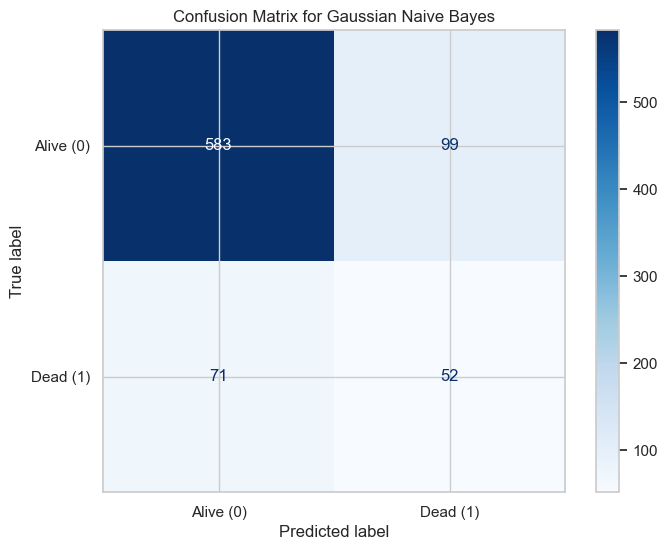


--- Initial Model Training Complete ---


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    ConfusionMatrixDisplay,
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Set plot style
sns.set(style="whitegrid")

# --- 1. Load Preprocessed Data ---
print("Loading preprocessed data...")
try:
    X_train = pd.read_csv("X_train_processed.csv")
    y_train = pd.read_csv("y_train.csv").iloc[:, 0]  # Use .iloc to get it as a Series
    X_test = pd.read_csv("X_test_processed.csv")
    y_test = pd.read_csv("y_test.csv").iloc[:, 0]  # Use .iloc to get it as a Series

    print("Data loaded successfully.")
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")

except FileNotFoundError as e:
    print(f"Error: {e}")
    print(
        "Please make sure the preprocessed files (X_train_processed.csv, etc.) are in the same directory."
    )
    # Exit or raise error if files not found
    exit()

# --- 2. Initialize Baseline Models ---
# Create a dictionary of models to train
# We use random_state=42 for reproducibility
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "k-NN (k=5)": KNeighborsClassifier(),
    "SVM": SVC(probability=True, random_state=42),  # probability=True for ROC-AUC
    "Gaussian Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
}

# --- 3. Train and Evaluate Models ---
results_list = []

for name, model in models.items():
    print(f"\n--- Training {name} ---")

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Get prediction probabilities for ROC-AUC
    # We check if the model supports predict_proba
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]  # Probability of class 1 ('Dead')
    else:
        y_prob = model.decision_function(X_test)

    # Calculate metrics
    # Note: For 'Dead' (class 1), which is our positive class
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Store results in a dictionary
    model_results = {
        "Model": name,
        "Accuracy": accuracy,
        "Precision (for 1:Dead)": precision,
        "Recall (for 1:Dead)": recall,
        "F1-Score (for 1:Dead)": f1,
        "ROC-AUC": roc_auc,
    }

    results_list.append(model_results)

    # Print a detailed classification report for each model
    print(f"\nClassification Report for {name}:\n")
    print(classification_report(y_test, y_pred, target_names=["Alive (0)", "Dead (1)"]))

# --- 4. Display Final Performance Summary ---
print("\n" + "=" * 80)
print("           MODEL PERFORMANCE SUMMARY (Baseline Models)")
print("=" * 80)

# Convert the results list to a DataFrame for easy viewing
results_df = pd.DataFrame(results_list)

# Sort by Recall (most important for minimizing false negatives) and F1-Score
results_df = results_df.sort_values(
    by=["Recall (for 1:Dead)", "F1-Score (for 1:Dead)"], ascending=False
)
results_df = results_df.set_index("Model")

# Print the formatted table
print(results_df.to_string(float_format="{:,.4f}".format))

# --- 5. (Optional) Visualize Best Model's Confusion Matrix ---
print("\n" + "=" * 80)
print("         CONFUSION MATRIX FOR BEST MODEL")
print("=" * 80)

# Get the name of the best model (top row of our sorted DataFrame)
best_model_name = results_df.index[0]
best_model = models[best_model_name]

print(f"Plotting Confusion Matrix for: {best_model_name}")

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(
    best_model,
    X_test,
    y_test,
    display_labels=["Alive (0)", "Dead (1)"],
    cmap="Blues",
    ax=ax,
)
plt.title(f"Confusion Matrix for {best_model_name}")
plt.show()

print("\n--- Initial Model Training Complete ---")

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
)

# --- Import Models ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    StackingClassifier,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# --- Import Tools ---
from sklearn.model_selection import GridSearchCV

# Set plot style
sns.set(style="whitegrid")

# --- 1. Load Preprocessed Data ---
print("Loading preprocessed data...")
try:
    X_train = pd.read_csv("X_train_processed.csv")
    y_train = pd.read_csv("y_train.csv").iloc[:, 0]
    X_test = pd.read_csv("X_test_processed.csv")
    y_test = pd.read_csv("y_test.csv").iloc[:, 0]

    print("Data loaded successfully.")
    print(f"X_train shape: {X_train.shape}")

except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please make sure the preprocessed files are in the same directory.")
    exit()

# This list will store all our results for the final report
results_list = []

# --- 2. Experiment 1: Run Baseline Models ---
print("\n--- Experiment 1: Running Baseline Models ---")

# We can re-use the models from your previous script
base_models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
}

for name, model in base_models.items():
    print(f"Training {name} (Baseline)...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    results_list.append(
        {
            "Model": name + " (Baseline)",
            "Accuracy": accuracy_score(y_test, y_pred),
            "Recall (1:Dead)": recall_score(y_test, y_pred, pos_label=1),
            "F1-Score (1:Dead)": f1_score(y_test, y_pred, pos_label=1),
            "ROC-AUC": roc_auc_score(y_test, y_prob),
        }
    )
print("Baseline models complete.")

# --- 3. Experiment 2: Hyperparameter Tuning (GridSearchCV) ---
print("\n--- Experiment 2: Hyperparameter Tuning Random Forest ---")

param_grid_rf = {
    "n_estimators": [100, 200],  # Number of trees
    "max_depth": [10, 20],  # Max depth of trees
    "min_samples_leaf": [2, 4],  # Min samples at each leaf node
    "class_weight": [None, "balanced"],  # Added to address imbalance
}

# Use 'f1' as the scoring metric
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=3,  # 3-fold cross-validation
    scoring="f1",
    n_jobs=-1,  # Use all available CPU cores
    verbose=1,
)

grid_search_rf.fit(X_train, y_train)
print(f"Best RF Params: {grid_search_rf.best_params_}")
best_rf = grid_search_rf.best_estimator_

# Evaluate the best tuned model
y_pred_rf_tuned = best_rf.predict(X_test)
y_prob_rf_tuned = best_rf.predict_proba(X_test)[:, 1]

results_list.append(
    {
        "Model": "Random Forest (Tuned)",
        "Accuracy": accuracy_score(y_test, y_pred_rf_tuned),
        "Recall (1:Dead)": recall_score(y_test, y_pred_rf_tuned, pos_label=1),
        "F1-Score (1:Dead)": f1_score(y_test, y_pred_rf_tuned, pos_label=1),
        "ROC-AUC": roc_auc_score(y_test, y_prob_rf_tuned),
    }
)
print("Hyperparameter tuning complete.")

# --- 4. Experiment 3: Stacking Classifier (Proposed System) ---
print("\n--- Experiment 4: Building Stacking Classifier ---")
# This aligns with your project pitch

# Define the base estimators using our best models
base_estimators = [
    ("rf_tuned", best_rf),  # Use the best tuned RF from our grid search
    ("adaboost", AdaBoostClassifier(random_state=42)),
    ("svm_balanced", SVC(probability=True, random_state=42, class_weight="balanced")),
]

# Create the StackingClassifier with a Logistic Regression meta-classifier
stacking_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,  # Use 5-fold cross-validation on the base models
    n_jobs=-1,
    passthrough=True,  # Pass through the original data to the final estimator
)

stacking_model.fit(X_train, y_train)
y_pred_stack = stacking_model.predict(X_test)
y_prob_stack = stacking_model.predict_proba(X_test)[:, 1]

results_list.append(
    {
        "Model": "Stacking Classifier (Proposed)",
        "Accuracy": accuracy_score(y_test, y_pred_stack),
        "Recall (1:Dead)": recall_score(y_test, y_pred_stack, pos_label=1),
        "F1-Score (1:Dead)": f1_score(y_test, y_pred_stack, pos_label=1),
        "ROC-AUC": roc_auc_score(y_test, y_prob_stack),
    }
)
print("Stacking model training complete.")

# --- 5. Final Results Comparison ---
print("\n" + "=" * 80)
print("       COMPREHENSIVE MODEL PERFORMANCE SUMMARY (Checkpoint 2)")
print("=" * 80)

final_results_df = pd.DataFrame(results_list).set_index("Model")
# Sort by our most important metric: Recall
final_results_df = final_results_df.sort_values(
    by=["Recall (1:Dead)", "F1-Score (1:Dead)"], ascending=False
)

print(final_results_df.to_string(float_format="{:,.4f}".format))
print("\n--- Checkpoint 2 Script Complete ---")

Loading preprocessed data...
Data loaded successfully.
X_train shape: (3219, 34)

--- Experiment 1: Running Baseline Models ---
Training Logistic Regression (Baseline)...
Training Random Forest (Baseline)...
Training AdaBoost (Baseline)...
Training SVM (Baseline)...
Baseline models complete.

--- Experiment 2: Hyperparameter Tuning Random Forest ---
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best RF Params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 100}
Hyperparameter tuning complete.

--- Experiment 4: Building Stacking Classifier ---
Stacking model training complete.

       COMPREHENSIVE MODEL PERFORMANCE SUMMARY (Checkpoint 2)
                                Accuracy  Recall (1:Dead)  F1-Score (1:Dead)  ROC-AUC
Model                                                                                
Random Forest (Tuned)             0.7901           0.4472             0.3943   0.7262
Random Forest (Baseline)          0.8447  

In [6]:
!pip install tensorflow

  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.7/200.7 MB 15.8 MB/s  0:00:12 eta 0:00:010:01:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 16.9 MB/s  0:00:00 17.0 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 676.9/676.9 kB 17.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 20.3 MB/s  0:00:001.8 MB/s eta 0:00:01
Using cached tensorboard_data_server-0.7.2-py3-none-any.whl (2.4 kB)
Using cached wheel-0.45.1-py3-none-any.whl (72 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 15.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 17.4 MB/s  0:00:01 17.6 MB/s eta 0:00:01
Using cached mdurl-0.1.2-py3-none-any.whl (10.0 kB)
   ━━━━━━━

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    ConfusionMatrixDisplay,
    roc_curve,
)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
sns.set(style="whitegrid")

print("Imports and setup complete")

Imports and setup complete


In [14]:
print("Loading preprocessed data...")
X_train = pd.read_csv("X_train_processed.csv")
y_train = pd.read_csv("y_train.csv").iloc[:, 0]
X_test = pd.read_csv("X_test_processed.csv")
y_test = pd.read_csv("y_test.csv").iloc[:, 0]

# Convert to numpy arrays for Keras
X_train_array = X_train.values
X_test_array = X_test.values
y_train_array = y_train.values
y_test_array = y_test.values

print(f"Data loaded successfully")
print(f"Training set: {X_train_array.shape}")
print(f"Test set: {X_test_array.shape}")

Loading preprocessed data...
Data loaded successfully
Training set: (3219, 34)
Test set: (805, 34)


In [15]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    "balanced", classes=np.unique(y_train_array), y=y_train_array
)
class_weight_dict = {i: float(weight) for i, weight in enumerate(class_weights)}

print("--- Class Distribution ---")
print(f"Class 0 (Alive) count: {(y_train_array == 0).sum()}")
print(f"Class 1 (Dead) count: {(y_train_array == 1).sum()}")
print(f"Class weights: {class_weight_dict}")
print("Class weights calculated")

--- Class Distribution ---
Class 0 (Alive) count: 2726
Class 1 (Dead) count: 493
Class weights: {0: 0.5904255319148937, 1: 3.264705882352941}
Class weights calculated


In [16]:
def focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal Loss for binary classification.

    Parameters:
    - gamma: Focusing parameter (default 2.0)
    - alpha: Balancing parameter (default 0.25)
    """

    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_loss = -alpha_t * tf.pow((1 - p_t), gamma) * tf.math.log(p_t)
        return tf.reduce_mean(focal_loss)

    return focal_loss_fixed


print("Focal Loss function defined")

Focal Loss function defined


In [34]:
# print("--- Building Improved MLP Architecture ---")
# print("Architecture: Input(34) → Dense(128, ReLU) → BatchNorm → Dropout(0.4)")
# print("              → Dense(64, ReLU) → BatchNorm → Dropout(0.3)")
# print("              → Dense(32, ReLU) → Dropout(0.2) → Output(1, Sigmoid)")

n_features = X_train_array.shape[1]

model_improved = keras.Sequential(
    [
        layers.Dense(128, activation="relu", input_shape=(n_features,)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(64, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(16, activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(1, activation="sigmoid"),
    ]
)

model_improved.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=["accuracy", "precision", "recall"],
)

print("\n--- Model Architecture Summary ---")
model_improved.summary()
print("\n Model built and compiled")


--- Model Architecture Summary ---


/Users/spacelord/Documents/ASU/Fall 2025/DM/project/venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 128)            │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,129 (63.00 KB)

 Trainable params: 15,745 (61.50 KB)

 Non-trainable params: 384 (1.50 KB)


 Model built and compiled


In [35]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor="val_loss", patience=15, restore_best_weights=True, verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, min_lr=1e-7, verbose=1
)

print("--- Training Improved MLP Model ---")
print("Training with:")
print(f"  - Epochs: 150 (with early stopping)")
print(f"  - Batch size: 64")
print(f"  - Validation split: 20%")
print(f"  - Class weights: Applied")
print()

history_improved = model_improved.fit(
    X_train_array,
    y_train_array,
    epochs=150,
    batch_size=64,
    validation_split=0.2,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
)

print("\n Model training complete")

--- Training Improved MLP Model ---
Training with:
  - Epochs: 150 (with early stopping)
  - Batch size: 64
  - Validation split: 20%
  - Class weights: Applied

Epoch 1/150


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7056 - loss: 0.1204 - precision: 0.1987 - recall: 0.3095 - val_accuracy: 0.8416 - val_loss: 0.0594 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8342 - loss: 0.0614 - precision: 0.3333 - recall: 0.0921 - val_accuracy: 0.8416 - val_loss: 0.0507 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8357 - loss: 0.0557 - precision: 0.3298 - recall: 0.0793 - val_accuracy: 0.8432 - val_loss: 0.0456 - val_precision: 1.0000 - val_recall: 0.0098 - learning_rate: 0.0010
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8365 - loss: 0.0517 - precision: 0.3026 - recall: 0.0588 - val_accuracy: 0.8416 - val_loss: 0.0423 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - ac

In [36]:
print("--- Optimizing Decision Threshold ---")
print("Finding optimal threshold to maximize F1-score...")

# Get prediction probabilities
y_pred_proba_train = model_improved.predict(X_train_array, verbose=0)
y_pred_proba_test = model_improved.predict(X_test_array, verbose=0)

# Try different thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
best_threshold = 0.5
best_f1 = 0

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba_train > threshold).astype(int).flatten()
    f1 = f1_score(y_train_array, y_pred_thresh, pos_label=1)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best threshold: {best_threshold:.3f} (F1-score: {best_f1:.4f})")

--- Optimizing Decision Threshold ---
Finding optimal threshold to maximize F1-score...
Best threshold: 0.350 (F1-score: 0.4313)


In [37]:
# Make predictions with optimized threshold
y_pred_improved = (y_pred_proba_test > best_threshold).astype(int).flatten()

# Calculate metrics
accuracy = accuracy_score(y_test_array, y_pred_improved)
precision = precision_score(y_test_array, y_pred_improved, pos_label=1)
recall = recall_score(y_test_array, y_pred_improved, pos_label=1)
f1 = f1_score(y_test_array, y_pred_improved, pos_label=1)
roc_auc = roc_auc_score(y_test_array, y_pred_proba_test)


print("           IMPROVED MLP MODEL - PERFORMANCE SUMMARY")
print(f"Accuracy:           {accuracy:.4f}")
print(f"Precision (Dead):   {precision:.4f}")
print(f"Recall (Dead):      {recall:.4f}")
print(f"F1-Score (Dead):    {f1:.4f}")
print(f"ROC-AUC:            {roc_auc:.4f}")
print(f"Optimal Threshold:  {best_threshold:.3f}")

# Compare with default threshold (0.5)
y_pred_default = (y_pred_proba_test > 0.5).astype(int).flatten()
print("\n--- Comparison: Default (0.5) vs Optimized Threshold ---")
print(f"Default (0.5):")
print(f"  Precision: {precision_score(y_test_array, y_pred_default, pos_label=1):.4f}")
print(f"  Recall:    {recall_score(y_test_array, y_pred_default, pos_label=1):.4f}")
print(f"  F1-Score:  {f1_score(y_test_array, y_pred_default, pos_label=1):.4f}")
print(f"\nOptimized ({best_threshold:.3f}):")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")
print("\n✓ Model evaluation complete")

           IMPROVED MLP MODEL - PERFORMANCE SUMMARY
Accuracy:           0.7938
Precision (Dead):   0.3407
Recall (Dead):      0.3740
F1-Score (Dead):    0.3566
ROC-AUC:            0.7328
Optimal Threshold:  0.350

--- Comparison: Default (0.5) vs Optimized Threshold ---
Default (0.5):
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

Optimized (0.350):
  Precision: 0.3407
  Recall:    0.3740
  F1-Score:  0.3566

✓ Model evaluation complete


/Users/spacelord/Documents/ASU/Fall 2025/DM/project/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


--- Plotting Training History ---


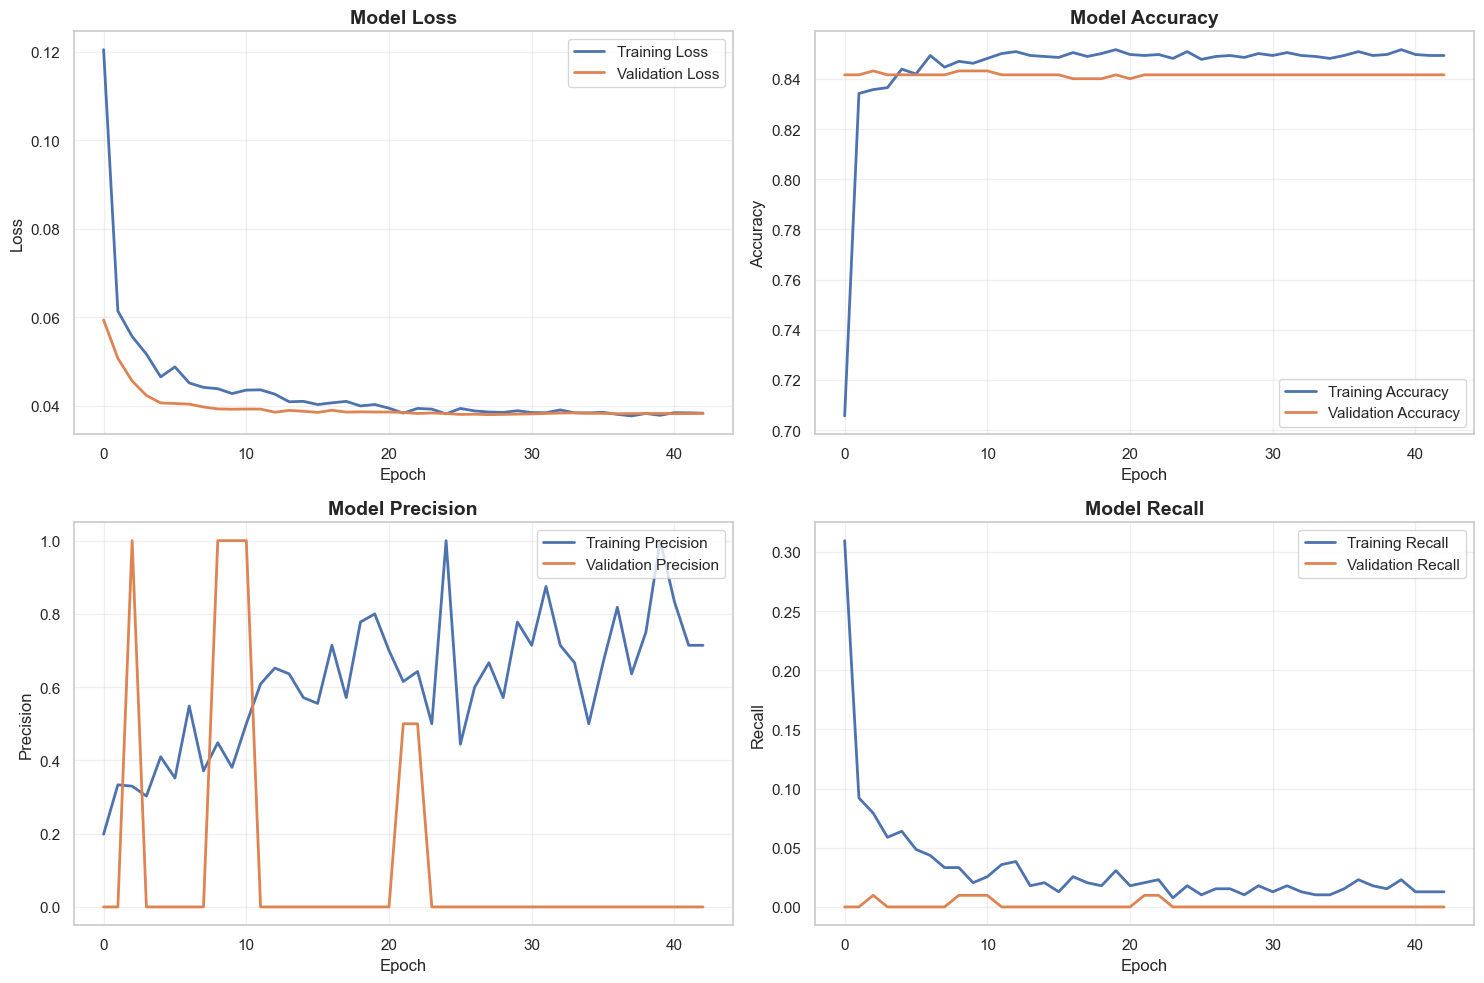

✓ Training history plots displayed


In [38]:
print("--- Plotting Training History ---")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot Loss
axes[0, 0].plot(history_improved.history["loss"], label="Training Loss", linewidth=2)
axes[0, 0].plot(
    history_improved.history["val_loss"], label="Validation Loss", linewidth=2
)
axes[0, 0].set_title("Model Loss", fontsize=14, fontweight="bold")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot Accuracy
axes[0, 1].plot(
    history_improved.history["accuracy"], label="Training Accuracy", linewidth=2
)
axes[0, 1].plot(
    history_improved.history["val_accuracy"], label="Validation Accuracy", linewidth=2
)
axes[0, 1].set_title("Model Accuracy", fontsize=14, fontweight="bold")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Accuracy")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot Precision
axes[1, 0].plot(
    history_improved.history["precision"], label="Training Precision", linewidth=2
)
axes[1, 0].plot(
    history_improved.history["val_precision"], label="Validation Precision", linewidth=2
)
axes[1, 0].set_title("Model Precision", fontsize=14, fontweight="bold")
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Precision")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot Recall
axes[1, 1].plot(
    history_improved.history["recall"], label="Training Recall", linewidth=2
)
axes[1, 1].plot(
    history_improved.history["val_recall"], label="Validation Recall", linewidth=2
)
axes[1, 1].set_title("Model Recall", fontsize=14, fontweight="bold")
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("Recall")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Training history plots displayed")

--- ROC Curve ---


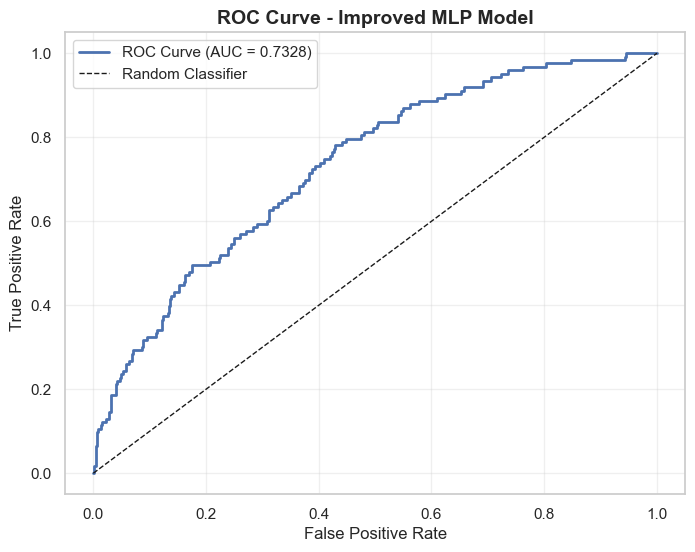


--- Confusion Matrix ---


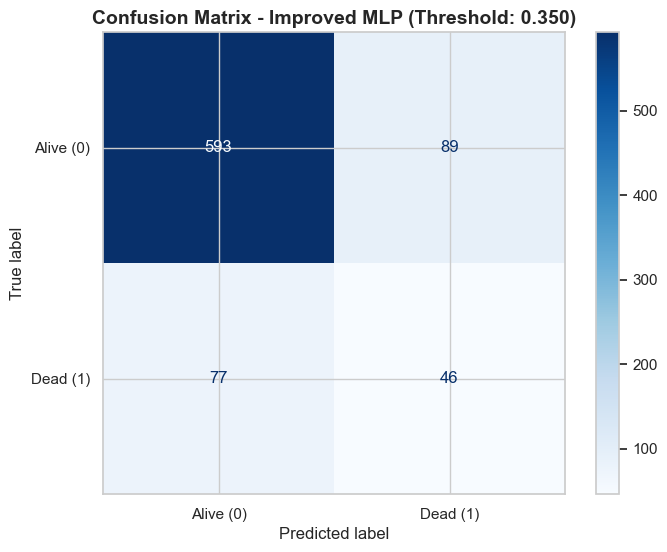

✓ ROC Curve and Confusion Matrix displayed

--- Improved MLP Model Complete ---


In [39]:
# ROC Curve
print("--- ROC Curve ---")
fpr, tpr, _ = roc_curve(y_test_array, y_pred_proba_test)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier", linewidth=1)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve - Improved MLP Model", fontsize=14, fontweight="bold")
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

# Confusion Matrix
print("\n--- Confusion Matrix ---")
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test_array,
    y_pred_improved,
    display_labels=["Alive (0)", "Dead (1)"],
    cmap="Blues",
    ax=ax,
    values_format="d",
)
plt.title(
    f"Confusion Matrix - Improved MLP (Threshold: {best_threshold:.3f})",
    fontsize=14,
    fontweight="bold",
)
plt.show()

print("✓ ROC Curve and Confusion Matrix displayed")
print("\n--- Improved MLP Model Complete ---")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

try:
    # Display prominent classification report
    print("           IMPROVED MLP MODEL - CLASSIFICATION REPORT")
    print(f"\nUsing Optimal Threshold: {best_threshold:.3f}\n")
    print(
        classification_report(
            y_test_array,
            y_pred_improved,
            target_names=["Alive (0)", "Dead (1)"],
            digits=4,
        )
    )

    # Display confusion matrix details
    print("           CONFUSION MATRIX DETAILS")
    cm = confusion_matrix(y_test_array, y_pred_improved)
    print(f"\nConfusion Matrix:")
    print(f"                Predicted")
    print(f"              Alive    Dead")
    print(f"Actual Alive    {cm[0,0]:4d}    {cm[0,1]:4d}")
    print(f"        Dead    {cm[1,0]:4d}    {cm[1,1]:4d}")

    print(f"\nDetailed Breakdown:")
    print(f"  True Negatives (TN):  {cm[0,0]:4d} - Alive correctly predicted as Alive")
    print(f"  False Positives (FP): {cm[0,1]:4d} - Alive incorrectly predicted as Dead")
    print(f"  False Negatives (FN): {cm[1,0]:4d} - Dead incorrectly predicted as Alive")
    print(f"  True Positives (TP):  {cm[1,1]:4d} - Dead correctly predicted as Dead")

    # Calculate additional metrics
    total = cm.sum()
    print(f"\nAdditional Metrics:")
    print(f"  Total Samples:       {total}")
    print(
        f"  Correct Predictions:  {cm[0,0] + cm[1,1]} ({100*(cm[0,0] + cm[1,1])/total:.2f}%)"
    )
    print(
        f"  Incorrect Predictions: {cm[0,1] + cm[1,0]} ({100*(cm[0,1] + cm[1,0])/total:.2f}%)"
    )
    print(" Classification report displayed")

except NameError:
    print("  ERROR: Model predictions not found!")
    print("  Please run all previous cells (Cells 5-14) first,")
    print("  then re-run this cell to display the classification report.")

           IMPROVED MLP MODEL - CLASSIFICATION REPORT

Using Optimal Threshold: 0.350

              precision    recall  f1-score   support

   Alive (0)     0.8851    0.8695    0.8772       682
    Dead (1)     0.3407    0.3740    0.3566       123

    accuracy                         0.7938       805
   macro avg     0.6129    0.6217    0.6169       805
weighted avg     0.8019    0.7938    0.7977       805

           CONFUSION MATRIX DETAILS

Confusion Matrix:
                Predicted
              Alive    Dead
Actual Alive     593      89
        Dead      77      46

Detailed Breakdown:
  True Negatives (TN):   593 - Alive correctly predicted as Alive
  False Positives (FP):   89 - Alive incorrectly predicted as Dead
  False Negatives (FN):   77 - Dead incorrectly predicted as Alive
  True Positives (TP):    46 - Dead correctly predicted as Dead

Additional Metrics:
  Total Samples:       805
  Correct Predictions:  639 (79.38%)
  Incorrect Predictions: 166 (20.62%)
 Classifica